In [18]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

from random import randint, uniform
from copy import deepcopy

In [2]:
# Dataset reading helpers

def read_objects(f):
    N = int(f.readline())
    objects = [[] for i in range(N)]
    targets = []
    for i in range(N):
        n = f.readline()
        iter = n.split()
        objects[i] = [int(s) for s in iter]
        targets.append(objects[i].pop())
    return (objects, targets)
    

def read_dataset(path_to_file):
    f = open(path_to_file, 'r')
    f.readline()
    
    train = read_objects(f)
    test = read_objects(f)

    f.close()
    return (train, test)

In [3]:
# Normalization

def normalize_matrix(objects):
    minmax = list(zip(objects[0], objects[0]))
    for o in objects:
        for i in range(len(o)):
            minmax[i] = (min(minmax[i][0], o[i]), max(minmax[i][1], o[i]))
    for o in objects:
        for i in range(len(o)):
            if minmax[i][0] == minmax[i][1]:
                minmax[i] = (minmax[i][1] / 2, minmax[i][1])
            o[i] = (o[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
    return minmax


def denormalize(w, MM1):
    new_w = [w[i] / (MM1[i][1] - MM1[i][0]) for i in range(len(w) - 1)]
    new_w.append(w[-1])
    for i in range(len(w) - 1):
        new_w[-1] -= w[i] * MM1[i][0] / (MM1[i][1] - MM1[i][0])
    return new_w

In [4]:
# Helper functions

def sign(a):
    return (a > 0) - (a < 0)


def scalar(w, a):
    return sum(x * y for x, y in zip(w, a)) + w[-1]


def smape(w, o, t):
    y = scalar(w, o)
    return abs(y - t) / (abs(y) + abs(t))


def full_smape(w, objects, targets):
    ans = 0.0
    for i in range(len(objects)):
        ans += smape(w, objects[i], targets[i])
    return ans / len(objects)


def mse(w, o, t):
    return (scalar(w, o) - t) * (scalar(w, o) - t) 


def full_mse(w, objects, targets):
    ans = 0.0
    for i in range(len(objects)):
        ans += mse(w, objects[i], targets[i])
    return ans / len(objects)

In [5]:
# Gradient descent

def gradient_smape(w, a, t):
    f = scalar(w, a)
    tt = abs(f) + abs(t)
    temp = sign(f - t) / tt - (sign(f) / tt) * (abs(f - t) / tt)
    return [x * temp for x in a] + [temp]


def gradient_mse(w, a, t):
    temp = 2 * (scalar(w, a) - t)
    return [x * temp for x in a] + [temp]


def get_rate(w, g, o, t):
    temp = scalar(g, o)
    diff = scalar(w, o) - t
    return 0 if temp == 0 else diff / temp


def grad_descent(in_objects, in_targets, reg, iters):
    objects = deepcopy(in_objects)
    targets = deepcopy(in_targets)
    
    MM = normalize_matrix(objects)
    M = len(objects[0]) + 1
    total = len(objects)
    eps = 0.0001
    rounds = 5
    
    for r in range(1, rounds):
        w = [uniform(-1 / (2 * M), 1 / (2 * M)) for i in range(M)]
        Q = full_mse(w, objects, targets)
        for j in range(1, iters):
            if (Q < eps) and (j != 1 and s < eps):
                break

            ind = randint(0, total - 1)
            g = gradient_mse(w, objects[ind], targets[ind])
            rate = get_rate(w, g, objects[ind], targets[ind])

            new_w = [x * (1 - rate * reg) - y * rate for x, y in zip(w, g)]
            p = mse(new_w, objects[ind], targets[ind])
            
            Q = rate * p + (1 - rate) * Q
            s = sum(abs(x - y) for x, y in zip(w, new_w))
            
            w = new_w
        Q = full_mse(w, objects, targets)
        if r == 1 or Q < best_Q:
            best = w
            best_Q = Q
    best = denormalize(best, MM)
    return best

In [156]:
# Least squares


def least_squares(objects, targets, reg):
    a = np.asarray([np.asarray(i) for i in objects])
    b = np.asarray(targets)
    V, D, UT = la.svd(a, full_matrices=False)
    rank = la.matrix_rank(a)
    sigma_inv = np.diag(np.hstack([D[:rank] / (reg + (D[:rank]) ** 2), np.zeros(a.shape[1] - rank)]))
    ans = UT.T.dot(sigma_inv).dot(V.T).dot(b)
    return ans.tolist()

In [158]:
# Solve dataset (get smape for test objects)

def solve_with_grad(train, test, reg, iters):
    w = grad_descent(train[0], train[1], reg, iters)
    return full_smape(w, test[0], test[1])


def solve_with_least_squares(train, test, reg):
    w = least_squares(train[0], train[1], reg)
    return full_smape(w, test[0], test[1])

In [59]:
dataset = read_dataset("1.txt")

In [9]:
# Find results for gradient

results_for_grad = ([], [])
for i in range(1, 100):
    reg = 0.01 * i
    results_for_grad[0].append(reg)
    results_for_grad[1].append(solve_with_grad(dataset[0], dataset[1], reg, 100))

In [161]:
# Find results for least squares

results_for_squares = ([], [])
for i in range(1, 100):
    reg = 0.01 * i
    results_for_squares[0].append(reg)
    results_for_squares[1].append(solve_with_least_squares(dataset[0], dataset[1], reg))

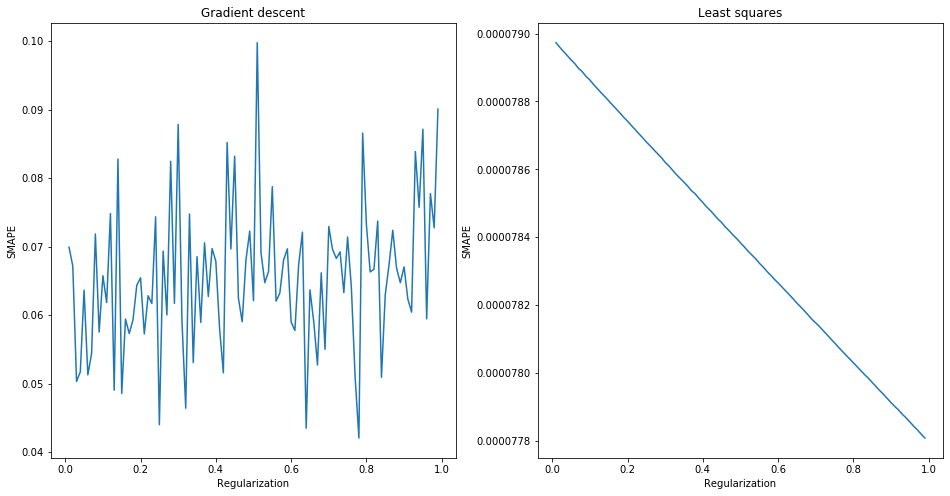

In [172]:
# Plots about reg

_, (x1, x2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

x1.plot(results_for_grad[0], results_for_grad[1])
x1.set_title("Gradient descent")
x1.set_ylabel("SMAPE")
x1.set_xlabel("Regularization")

x2.plot(results_for_squares[0], results_for_squares[1])
x2.set_title("Least squares")
x2.set_ylabel("SMAPE")
x2.set_xlabel("Regularization")
plt.show()

In [170]:
# Find best results

best_reg_for_grad = results_for_grad[0][results_for_grad[1].index(min(results_for_grad[1]))]
best_reg_for_squares = results_for_squares[0][results_for_squares[1].index(min(results_for_squares[1]))]
print("For gradient best reg = " + str(best_reg_for_grad))
print("For squares best reg = " + str(best_reg_for_squares))

For gradient best reg = 0.78
For squares best reg = 0.99


In [14]:
# Find results for grad with iters

results_for_grad_with_iters = ([], [])
for i in range(10, 2000, 10):
    results_for_grad_with_iters[0].append(i)
    results_for_grad_with_iters[1].append(solve_with_grad(dataset[0], dataset[1], best_reg_for_grad, i))

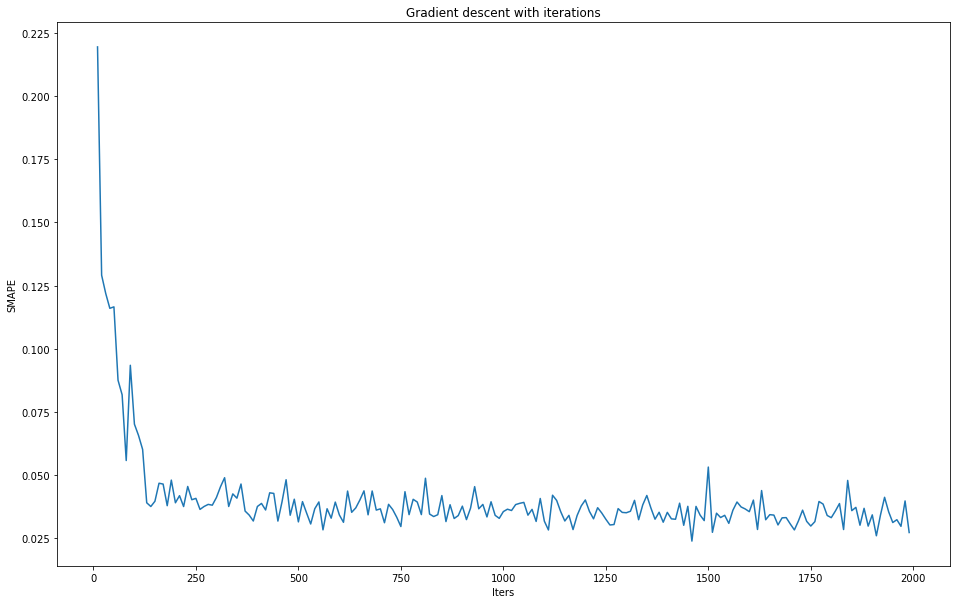

In [164]:
# Plot about gradient descent with iters

plt.figure(figsize=(16,10))
plt.plot(results_for_grad_with_iters[0], results_for_grad_with_iters[1])
plt.xlabel("Iters")
plt.ylabel("SMAPE")
plt.title("Gradient descent with iterations")
plt.show()